# All plots for the website

In [2]:
# Imports

# Usual imports
import os
import sys
import time
import datetime
import json
import csv
import glob
import pprint
import importlib
from tqdm import tqdm
from collections import Counter

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import itertools
import time
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-talk')

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Custom modules
sys.path.insert(0, '../')
import psychometry
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
#plt.rcParams.update({'font.size': 20})
style.use('seaborn-talk') #sets the size of the charts

# This is the color of sh.rice.edu/covid-sense website background. It is NOT white
bg_color = (0.96862745, 0.96862745, 0.96862745)

# Convert a timestamp into time string
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

In [3]:
# Load database
dbname = '../data/db_snapshot.json'

with open(dbname, 'rb') as readfile:
    db = json.load(readfile)
    
print('%d participants'%len(db))
print('%s responses'%len(utils.cat_arrays(db, 'timestamps')))

1188 participants
17193 responses


[233 419 356 169]


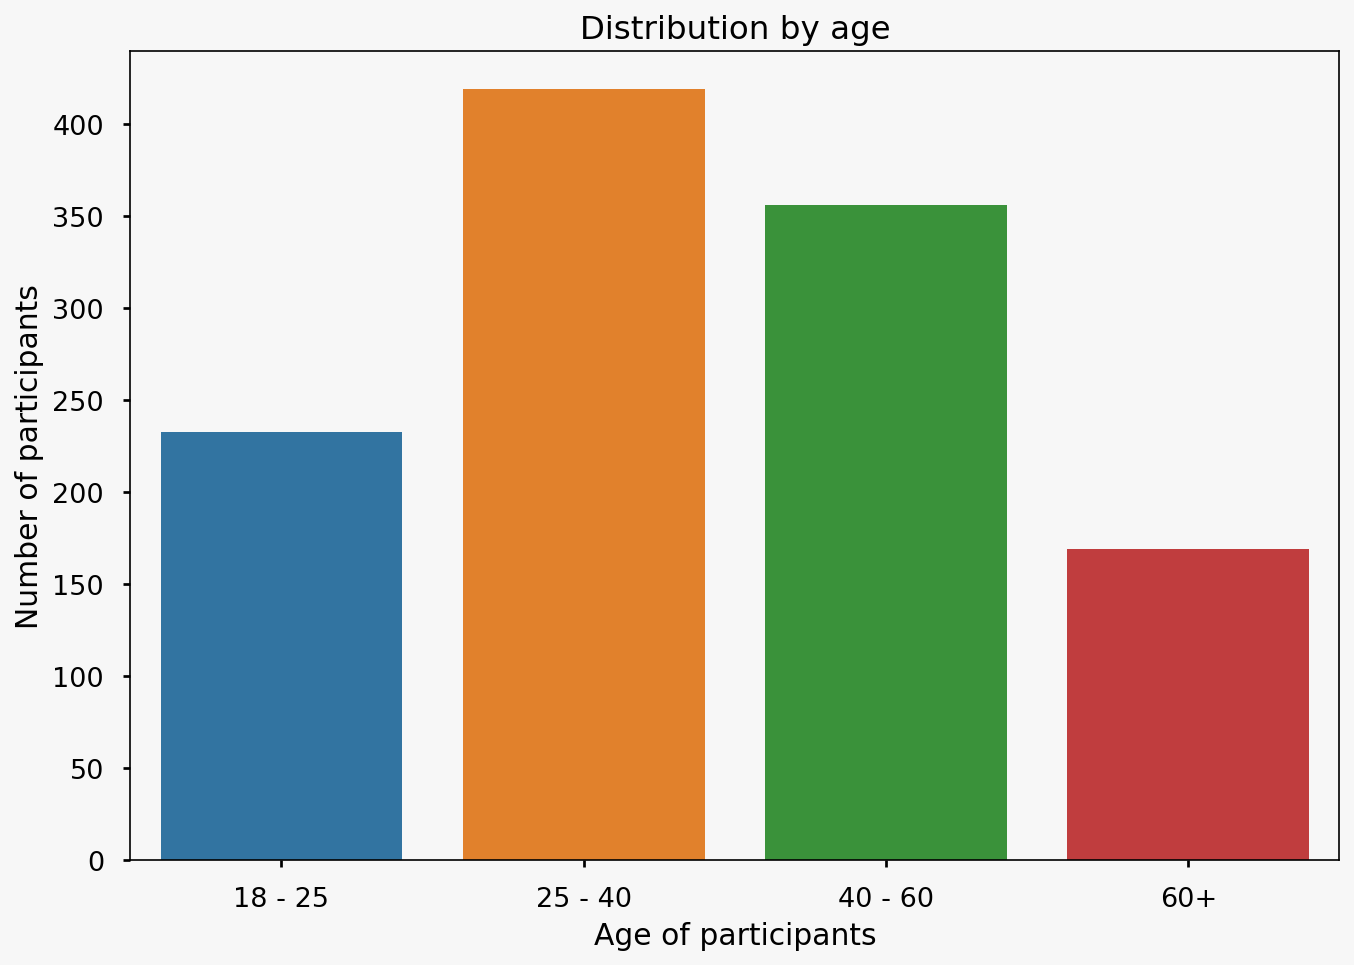

In [4]:
# Plot a histogram of participants by age
ages = utils.getall(db, 'age')

bins = [18, 25, 40, 60, 100]

vals, bins = np.histogram(ages, bins)
print(vals)

fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
sns.barplot([0, 1, 2, 3], vals)
plt.xlabel('Age of participants')
plt.ylabel('Number of participants')
plt.xticks([0, 1, 2, 3], labels=['18 - 25', '25 - 40', '40 - 60', '60+'])
plt.title('Distribution by age')
plt.show()

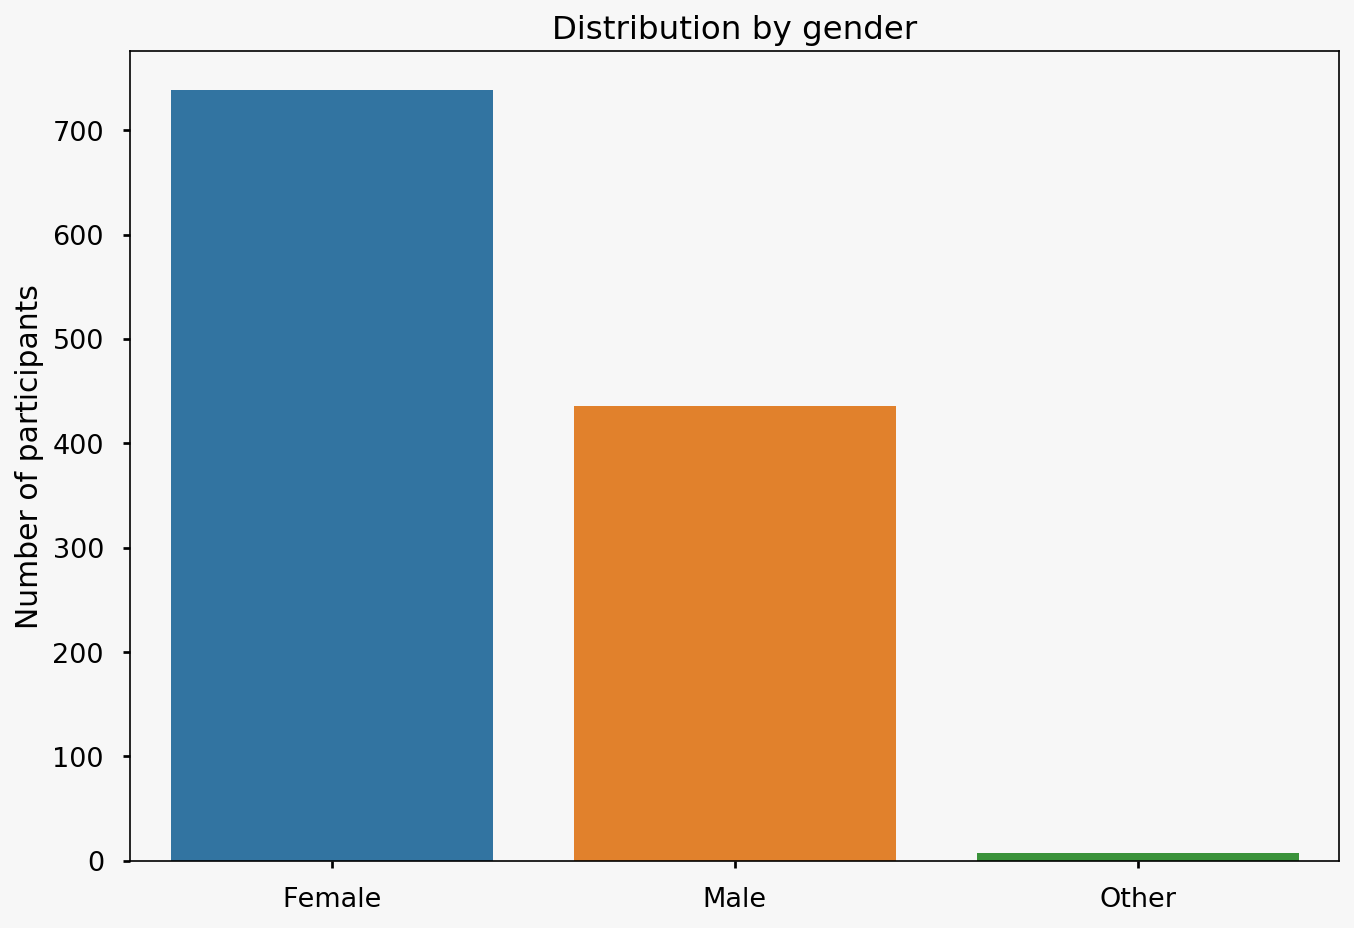

In [7]:
# Plot distribution by gender
genders = utils.getall(db, 'gender')

gender_counter = Counter(genders)
del gender_counter['prefer not to answer']

vals = np.array(list(gender_counter.values()))
labels = [label.capitalize() for label in list(gender_counter.keys())]

fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
sns.barplot(labels, vals)
plt.title('Distribution by gender')
plt.ylabel('Number of participants')
plt.show()

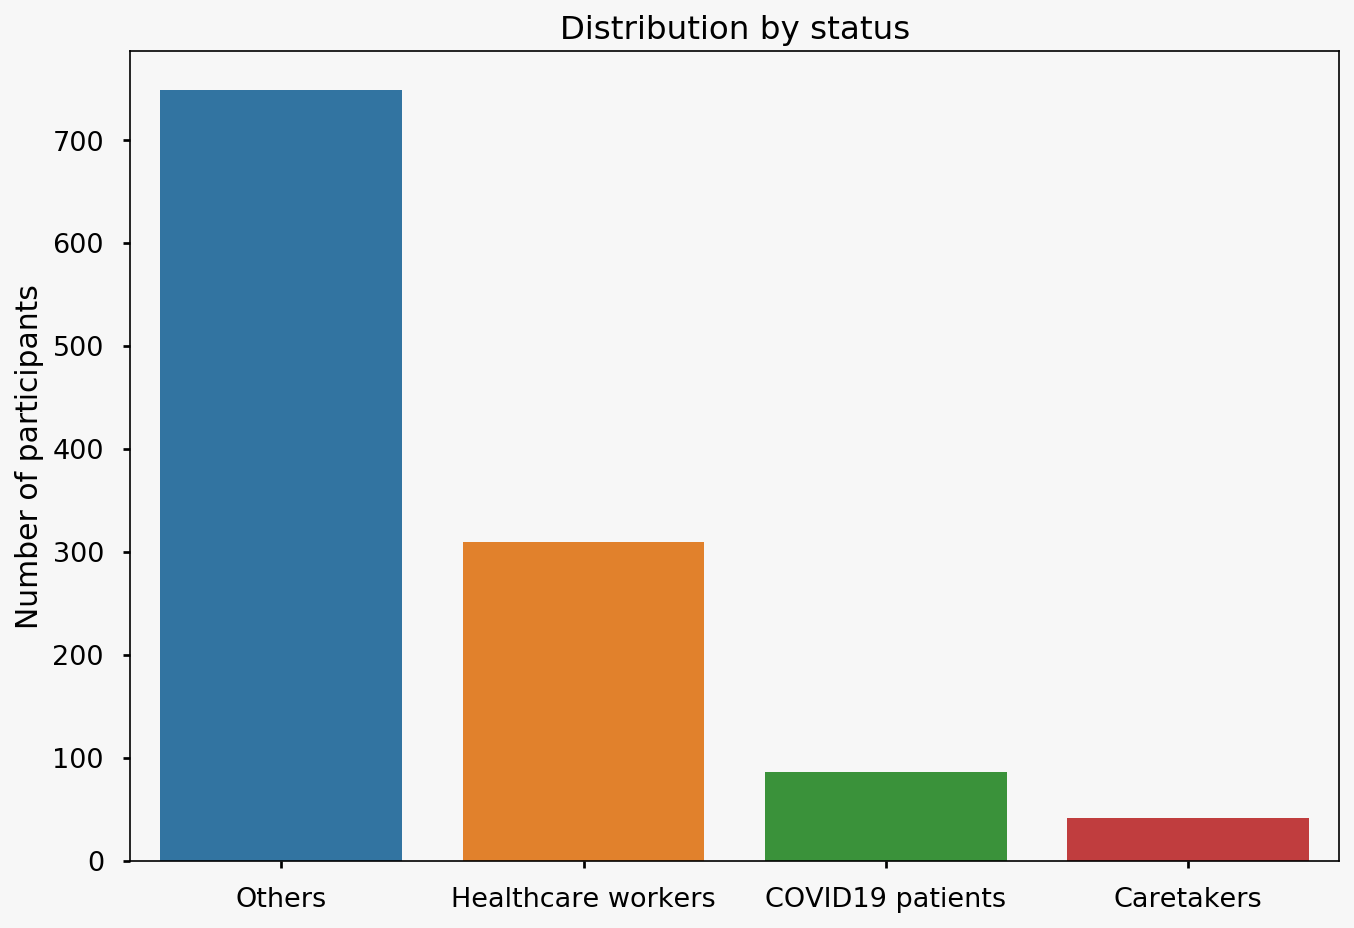

In [8]:
# Distribution by status
n_total = len(db)
n_healthcare = len([key for key in db if db[key]['healthcare_worker']])
n_covid = len([key for key in db if len(db[key]['I']) > 0])
n_caretaker = len([key for key in db if len(db[key]['M']) > 0])
n_others = n_total - n_healthcare - n_covid - n_caretaker

fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
sns.barplot(['Others', 'Healthcare workers', 'COVID19 patients', 'Caretakers'], 
            [n_others, n_healthcare, n_covid, n_caretaker])
plt.title('Distribution by status')
plt.ylabel('Number of participants')
plt.show()

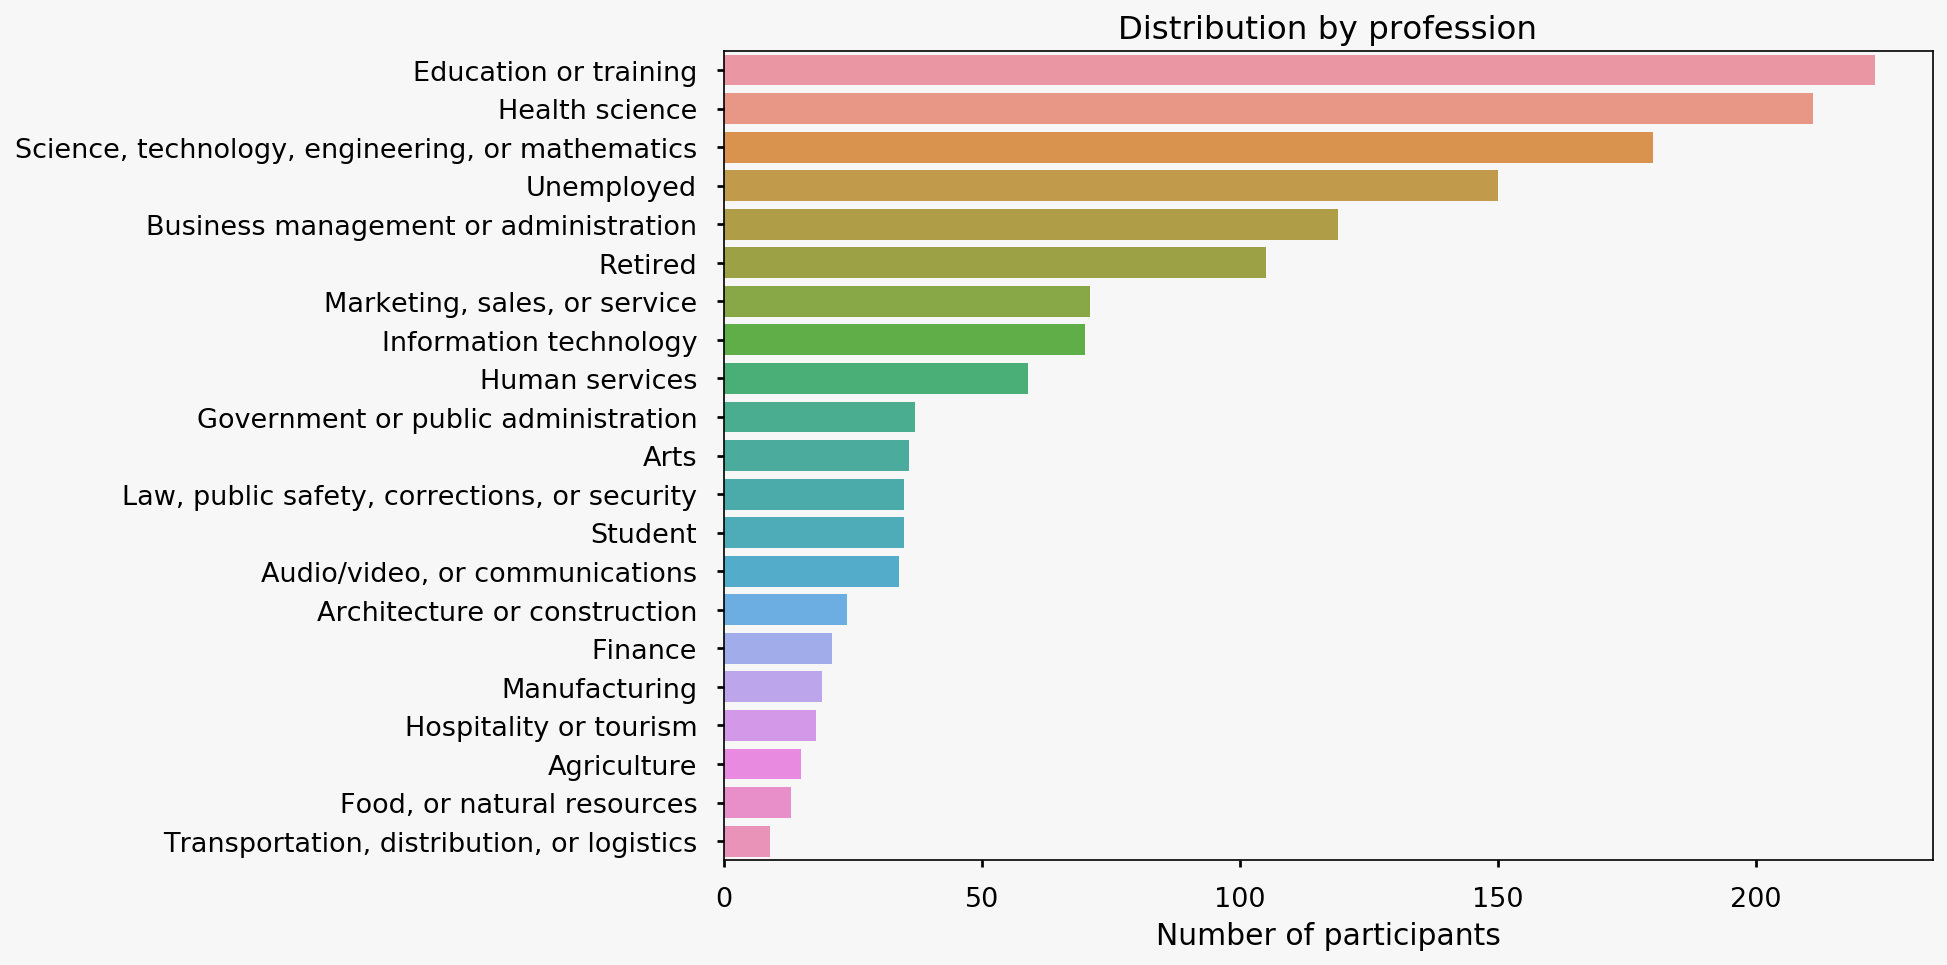

In [9]:
# Professions
professions = utils.cat_arrays(db, 'jobs')

pro_counter = Counter(professions)
labels = np.array([label.capitalize() for label in list(pro_counter.keys())])
values = np.array(list(pro_counter.values()))

valid_indices = np.where(values > 4)
labels = labels[valid_indices]
values = values[valid_indices]

indices = np.argsort(values)[::-1]
labels = labels[indices]
values = values[indices]

fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
sns.barplot(values, labels)
plt.xlabel('Number of participants')
plt.title('Distribution by profession')
plt.show()

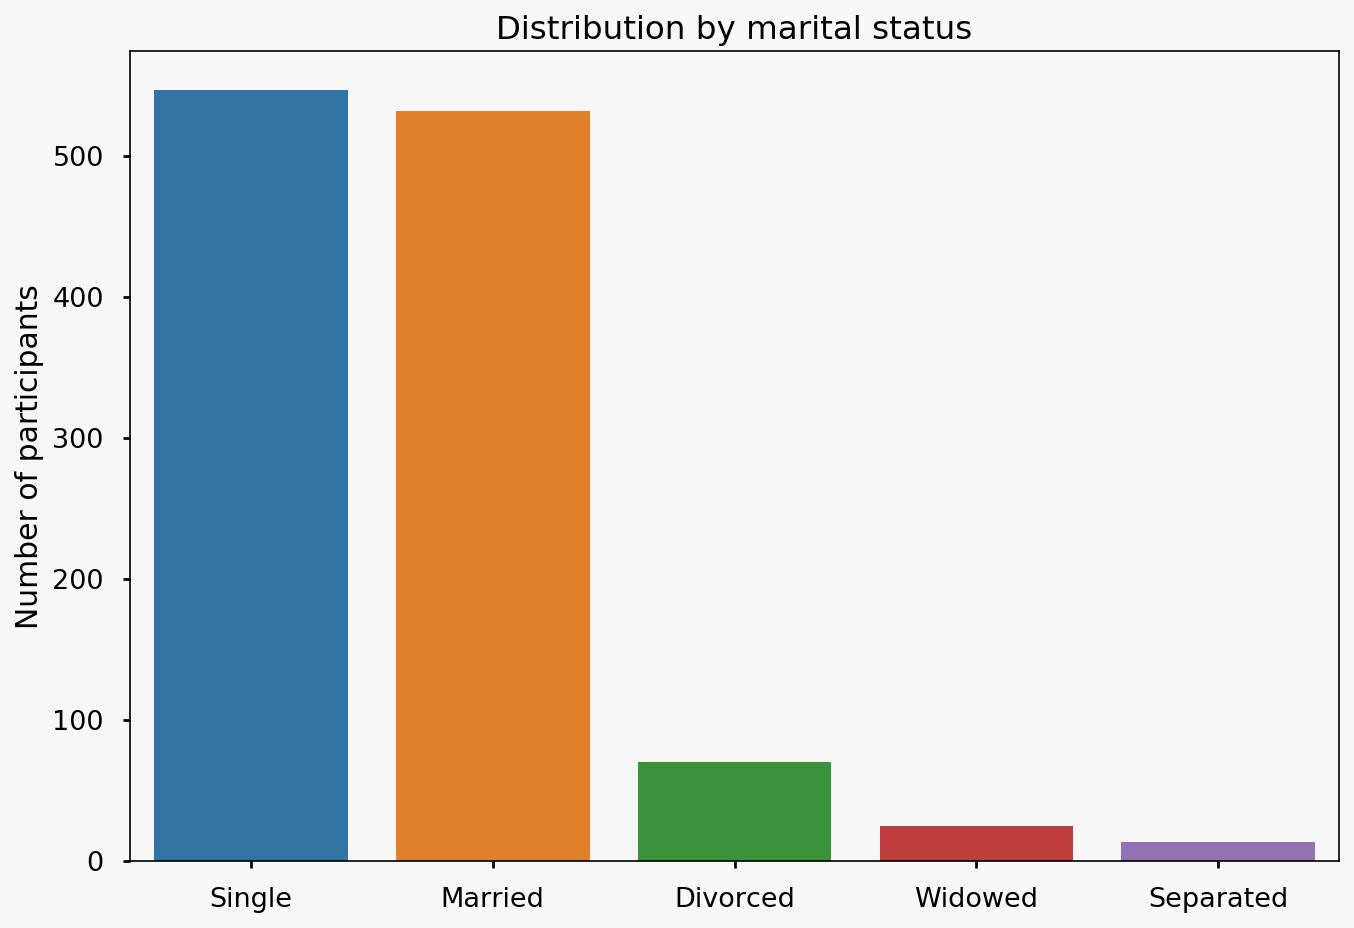

In [10]:
# Marital status
marital_counter = Counter(utils.getall(db, 'marital_status'))
vals = np.array(list(marital_counter.values()))
labels = np.array([label.capitalize() for label in list(marital_counter.keys())])

indices = np.argsort(vals)[::-1]
vals = vals[indices]
labels = labels[indices]

fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
sns.barplot(labels, vals)
plt.ylabel('Number of participants')
plt.title('Distribution by marital status')
plt.show()

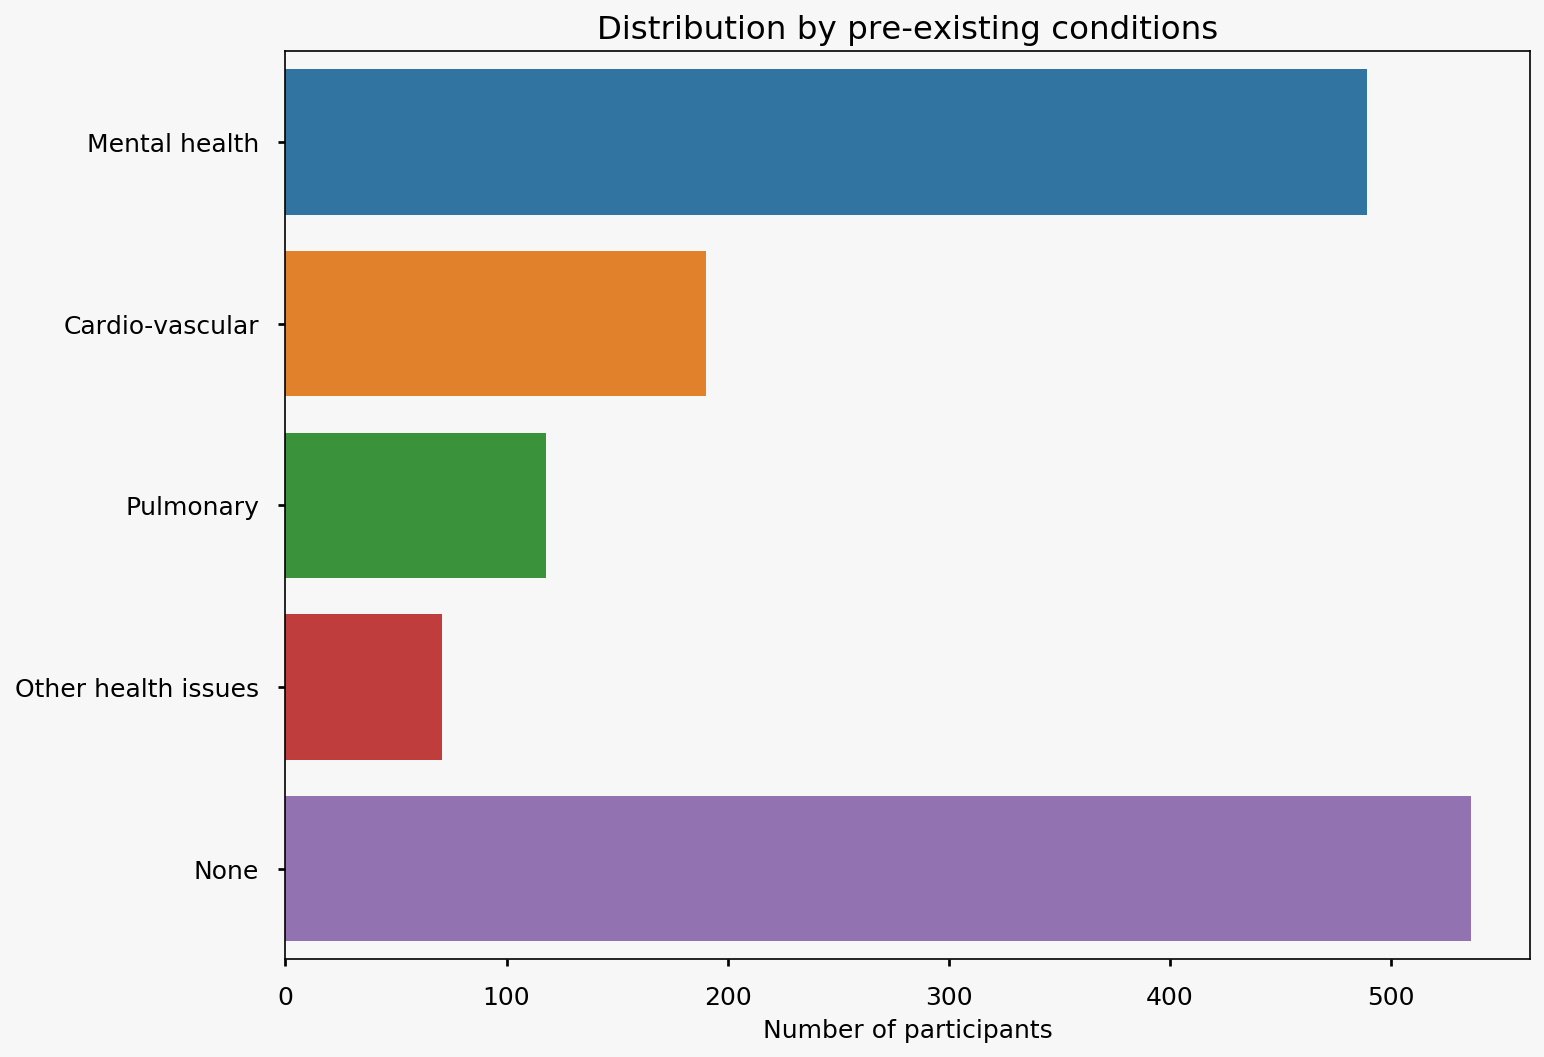

In [12]:
# Preexisting conditions
pre_physical = utils.getall(db, 'pre_physical')
pre_mental = utils.getall(db, 'pre_mental')

conversion_dict = {
    'None': ['none of the above', 'None', '(empty)'],
    'Mental health': ['depression', 'anxiety disorder',
               'other serious mental health issues',
               'obsessive compulsive disorder',
               'addiction (drug, alcohol)',
               'bipolar'],
    'Cardio-vascular': ['abnormal blood pressure',
                        'diabetes'],
    'Pulmonary': ['asthma', 'asthma, COPD or other lung disease'],
    'Other health issues': ['cancer', 'other serious health issues'] 
}
total_counter = {key:0 for key in conversion_dict}

for idx in range(len(pre_physical)):
    physical = pre_physical[idx]
    mental = pre_mental[idx]
    
    if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
       len(set(conversion_dict['None']).intersection(mental)) > 0:
        total_counter['None'] += 1
    else:
        if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
            total_counter['Mental health'] += 1
        if len(set(conversion_dict['Cardio-vascular']).intersection(physical)) > 0:
            total_counter['Cardio-vascular'] += 1
        elif len(set(conversion_dict['Pulmonary']).intersection(physical)) > 0:
            total_counter['Pulmonary'] += 1
        elif len(set(conversion_dict['Other health issues']).intersection(physical)) > 0:
            total_counter['Other health issues'] += 1

names = np.array([key.capitalize() for key in total_counter])
values = np.array([total_counter[key] for key in total_counter])
#indices = np.argsort(values)[::-1]
indices = [1, 2, 3, 4, 0]

fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
handle = sns.barplot(values[indices], names[indices])
plt.xlabel('Number of participants', fontsize=12)
plt.title('Distribution by pre-existing conditions')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [28]:
# Delta qids as a function of time
const = 60*60*24*4

qids_ids = [key for key in db if \
            len(db[key]['QIDS']) > 1 and \
            #'state' in db[key] and \
            #db[key]['state'] == 'Texas' and\
            len(db[key]['pre_physical']) > 0 and\
            'None' not in db[key]['pre_physical'] and\
            'none of the above' not in db[key]['pre_physical'] and\
            '(empty)' not in db[key]['pre_physical']]
            #db[key]['healthcare_worker']]

qids_dict = {key:db[key] for key in qids_ids}
print(len(qids_dict))
pprint.pprint(Counter(utils.cat_arrays(qids_dict, 'pre_physical')))

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = int(datetime.date.today().strftime('%s'))

ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))

d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%m %d')
d2s2 = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

data_dict = {'delta_qids': [],
             'qids': [],
             'nresponses': [],
             'timestamp': [],
             'timestring': [],
             'timestring2': [],
             'gender': []}

for key in qids_dict:
    qids = qids_dict[key]['QIDS']
    values = np.array(list(qids.values()))
    #values = values + 0.5*np.random.rand(values.size) - 0.25
    timestamps = np.array([float(key) for key in list(qids.keys())])*1000
    indices = np.argsort(timestamps)[::-1]

    for idx in range(indices.size-1):
        time_stamp = const*(timestamps[indices[idx]]//(const*1000))
        data_dict['timestamp'].append(time_stamp)
        data_dict['nresponses'].append(1)
        data_dict['qids'].append(values[indices[idx]])
        data_dict['timestring'].append(d2s(time_stamp*1000))
        data_dict['timestring2'].append(d2s2(time_stamp*1000))
        data_dict['gender'].append(qids_dict[key]['gender'])

        delta_qids = values[indices[idx]] - values[indices[idx+1]]
        data_dict['delta_qids'].append(delta_qids)

data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')

pprint.pprint(db['52']['QIDS'])
qids_val = list(db['52']['QIDS'].keys())[0]

print(d2s(float(qids_val)*1000))

249
Counter({'abnormal blood pressure': 108,
         'other serious health issues': 88,
         'asthma': 46,
         'asthma, COPD or other lung disease': 44,
         'diabetes': 33,
         'cancer': 13})
{'1586231288.0': 5, '1586834639.0': 3, '1588052059.0': 3, '1589262782.0': 5}
04 28


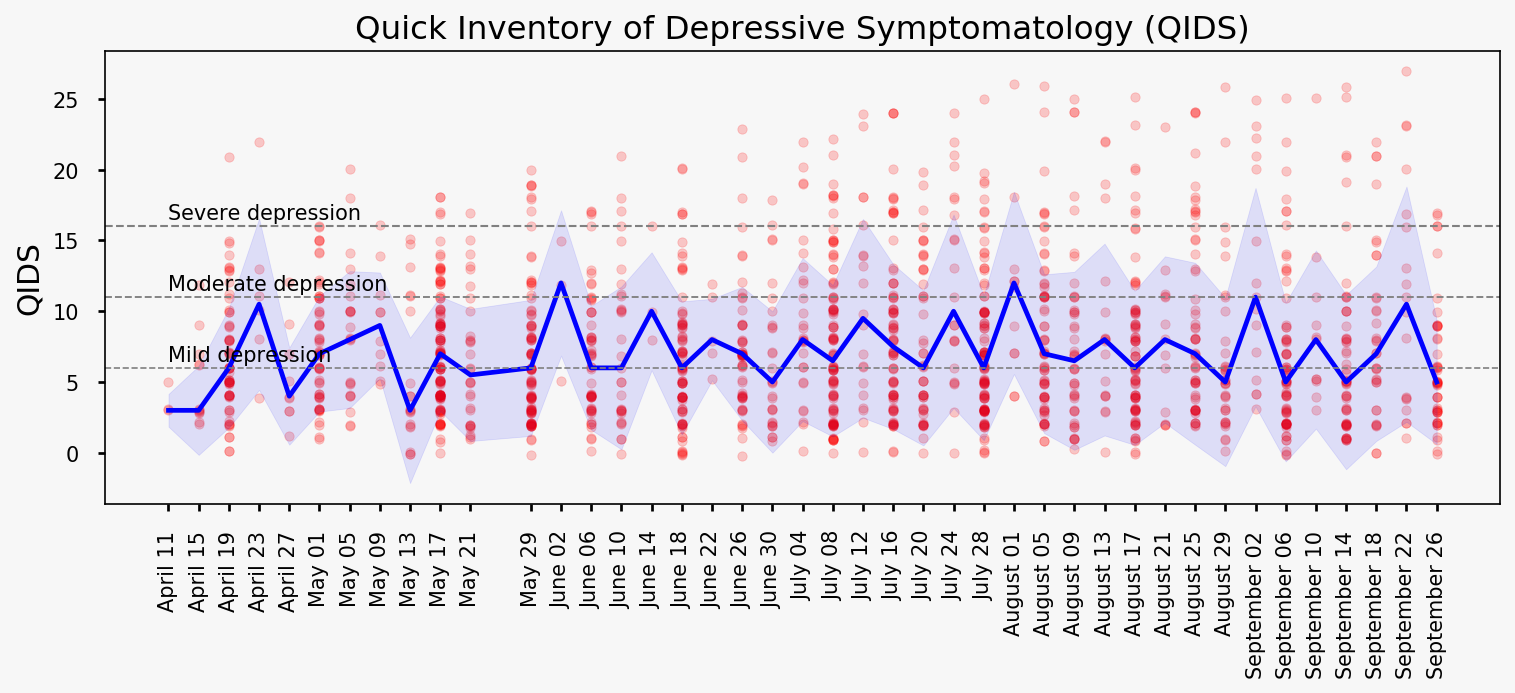

In [29]:
# QIDS averaging a la Ashok
winsize = 14

data_pd_dict = pd.DataFrame.to_dict(data_pd[['qids', 'timestamp', 'nresponses']])
#qids_array = np.array(list(data_pd_dict['qids'].values()))
timestamp_array = np.array(list(data_pd_dict['timestamp'].values()))
#nresponses_array = np.array(list(data_pd_dict['nresponses'].values()))

timestamps = np.unique(timestamp_array)
data_pd_agg = data_pd[['qids', 'timestamp', 'nresponses']].groupby(by='timestamp').agg({'qids': 'median', 'nresponses': 'sum'})
data_pd_std = data_pd[['qids', 'timestamp', 'nresponses']].groupby(by='timestamp').agg({'qids': 'std'})
qids_array = np.array(list(pd.DataFrame.to_dict(data_pd_agg)['qids'].values()))
qids_std_array = np.array(list(pd.DataFrame.to_dict(data_pd_std)['qids'].values()))
nresponses_array = np.array(list(pd.DataFrame.to_dict(data_pd_agg)['nresponses'].values()))

# Moving average the data
#qids_array = np.convolve(qids_array, np.ones(winsize)/winsize, 'same')
#timestamp_array = np.convolve(timestamp_array, np.ones(winsize)/winsize, 'valid')

fig, ax = plt.subplots(dpi=150, figsize=[12, 4])
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
qids_vals = np.array(list(data_pd_dict['qids'].values())) + np.random.randn(len(timestamp_array))/10
ax.scatter(timestamp_array, qids_vals, marker='o', 
            edgecolors='r', facecolors='r', alpha=0.2, s=20)
ax.plot(timestamps, qids_array, 'b-')

ax.fill_between(timestamps, qids_array - qids_std_array, qids_array + qids_std_array, alpha=0.1, color='b')
#ax.plot(timestamps, qids_array + qids_std_array, 'b--', linewidth=1.0)
#ax.plot(timestamps, qids_array - qids_std_array, 'b--', linewidth=1.0)
_ = plt.xticks(timestamps, labels=[d2s2(x*1000) for x in timestamps], rotation='vertical', fontsize=10)
_ = plt.yticks(fontsize=10)

# Add horizontal lines differentiating into various zones
plt.axhline(y=6.0, linestyle='--', color='gray', linewidth=0.8)
plt.annotate('Mild depression', xy=(timestamps[0], 6.5))

plt.axhline(y=11.0, linestyle='--', color='gray', linewidth=0.9)
plt.annotate('Moderate depression', xy=(timestamps[0], 11.5))

plt.axhline(y=16.0, linestyle='--', color='gray', linewidth=1.0)
plt.annotate('Severe depression', xy=(timestamps[0], 16.5))

plt.ylabel('QIDS')
plt.title('Quick Inventory of Depressive Symptomatology (QIDS)')
plt.show()
#plt.plot(timestamp_array, qids_array)